# Resrouce Library 

### Resource file name: Geo out

##### Topic: Death Rates by County (and State) plus counties geo locations

Source: Geo Notebook

In [1]:
import censusdata
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import numpy as np
from scipy import stats
import gmaps

In [2]:
# Specify path to read file
geo = os.path.join("Resources", "Geo out.csv") # Imported from Geo notebook so that API doesn't have to be called each time & United States Cancer Statistics
states = os.path.join("Resources", "geocodes.xlsx") # Imported from census data to help map differnt state and county syntaxs

# Read in pandas
geo_df = pd.read_csv(geo)  
states_df = pd.read_excel(states, index_col=None, convert_float=False) 

In [3]:
# Add State and County Codes using substrings in order to join for geo locations later
geo_df["State_County"] = geo_df.County.str.split('(').str[1]
geo_df["State_County"] = geo_df.State_County.str.split(')').str[0]
geo_df["State_ID"] = geo_df.State_County.str.slice(start=0, stop=2).astype(int)
geo_df["County_ID"] = geo_df.State_County.str.slice(start=2, stop=5).astype(int)

In [4]:
# Filter for only County Codes
counties_df = states_df.loc[states_df['SummaryLevel'] == 50]

In [5]:
# Merge geo locations with stanard state and county syntax
geo_states_df = pd.merge(counties_df, geo_df, left_on=["StateCode", "CountyCode"], right_on = ["State_ID","County_ID"], how="inner")

In [6]:
# Download ACS 2013-2017 5-year estimates on population size, median age, and median household income,etc
data = censusdata.download('acs5', 2017, censusdata.censusgeo([('county', '*')]), ['B01001_001E', 'B01002_001E', 'B19013_001E','B12006_006E','B12006_011E','B17005_006E', "B17005_011E", "C27016_041E", "B19215_005E", "B19215_008E", "B09019_027E", "B09019_030E","B19301_001E","B17001_002E","B28008_010E","B992701_003E"])

data_table = data.rename(columns={"B01001_001E": "population size", "B01002_001E": "median age",
                                  "B19013_001E" : "median household income", "B12006_006E" : "NeverMarried Unemployed Male", 
                                  "B12006_011E" : "NeverMarried Unemployed Female", "B17005_006E" : "Unemployed Male below line", 
                                  "B17005_011E" : "Unemployed Female below line", "C27016_041E" : "4.00 of poverty threshold 65 years and over No health insurance coverage",
                                  "B19215_005E" : "MEDIAN HOUSEHOLD INCOME Living Alone 65 and over", "B19215_008E" : "MEDIAN HOUSEHOLD INCOME Not Living Alone 65 and over",
                                  "B09019_027E" : "Male Living alone", "B09019_030E" : "Female Living alone",
                                  "B19301_001E": "Per Capita Income","B17001_002E": "Poverty Count",
                                  "B28008_010E" : "Total No Computer", "B992701_003E" : "Total No health insurance"})

In [7]:
# convert feilds to match for state and county merging with geo location  & death rate data
data_table.index = data_table.index.astype(str)
data_table["County_State"] = data_table.index.str.split(':').str[0]
data_table["County_Name"] = data_table.County_State.str.split(',').str[0]
data_table["State"] = data_table.County_State.str.split(',').str[1]
data_table["State_County"] = data_table.index.str.split('state:').str[1]
data_table["State_ID"] = data_table.State_County.str.split('>').str[0].astype(int)
data_table["County_ID"] = data_table.State_County.str.split('county:').str[1].astype(int)

In [8]:
# Merge with geo location  & death rate data
deathrates_census = pd.merge(geo_states_df, data_table, left_on=["StateCode","CountyCode"], right_on=["State_ID","County_ID"])

In [9]:
# Create new coloumns to divide count by population (matching apples to apples)
deathrates_census["Never Married Percentage"] = (deathrates_census["NeverMarried Unemployed Male"] +deathrates_census["NeverMarried Unemployed Female"]) / deathrates_census["population size"]
deathrates_census["Unemployed Below Line"] = (deathrates_census["Unemployed Male below line"] +deathrates_census["Unemployed Female below line"]) / deathrates_census["population size"]
deathrates_census["No Insurance"] = (deathrates_census["Total No health insurance"] ) / deathrates_census["population size"]
deathrates_census["Living Alone Percentage"] = (deathrates_census["Male Living alone"] +deathrates_census["Female Living alone"]) / deathrates_census["population size"]
deathrates_census["Income"] = (deathrates_census["median household income"] ) / 10000
deathrates_census["Poverty"] = (deathrates_census["Poverty Count"] ) / deathrates_census["population size"]
deathrates_census["No Computer"] = (deathrates_census["Total No Computer"] ) / deathrates_census["population size"]

In [10]:
# Export file for output to work with future dataset (i.e. weather or medically underserviced data)
compression_opts = dict(method='zip',
                        archive_name='Census out.csv')  
deathrates_census.to_csv('out.zip', index=False,
          compression=compression_opts)  

In [11]:
# Create summary for ploting
summary_df = deathrates_census[["State","County_Name","AGE_ADJUSTED_RATE", "Ratings","Never Married Percentage", "Unemployed Below Line", "No Insurance","Living Alone Percentage","median age","median household income","Poverty", "No Computer","lat","lng", "population size"]] 

y = -206.24x +84980.22
-0.4471349925351067


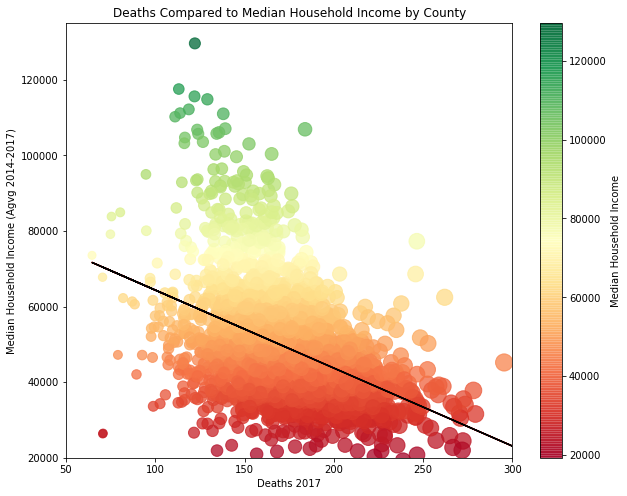

In [12]:
# Compare Deaths to median income
x_axis = summary_df.loc[:,"AGE_ADJUSTED_RATE"]
y_axis = summary_df.loc[:,'median household income']
s = summary_df.loc[:,'AGE_ADJUSTED_RATE']

# Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_axis, y_axis)

# Get regression values
regress_values = x_axis * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)

# Print Pearson's correlation coefficient (rvalue)
print(rvalue)

# Create Plot
plt.figure(figsize=(10,8))
plt.scatter(x_axis, y_axis, c=y_axis, 
            cmap = 'RdYlGn', s=s, alpha=0.75)
plt.plot(x_axis,regress_values,"r-")
plt.title('Deaths Compared to Median Household Income by County')
plt.xlabel('Deaths 2017')
plt.ylabel('Median Household Income (Avg for 5 years))')
plt.ylim(20000, 135000)
plt.xlim(50, 300)
plt.plot(x_axis,regress_values,"k-")
cbar = plt.colorbar()
cbar.set_label('Median Household Income')
plt.show()

y = -0.0x +0.86
-0.05485854522937422


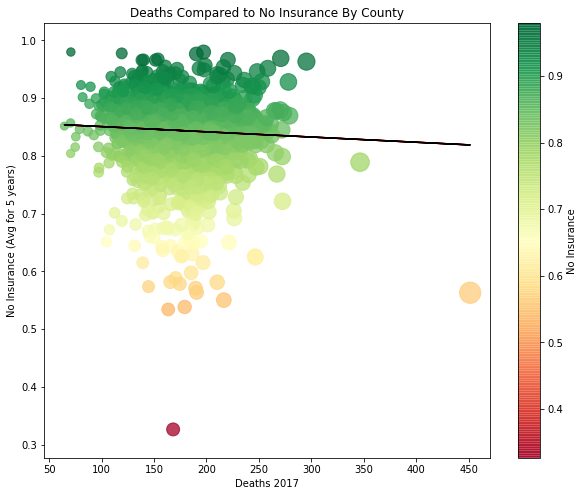

In [28]:
# Compare Deaths to no insurance
x_axis = summary_df.loc[:,"AGE_ADJUSTED_RATE"]
y_axis = summary_df.loc[:,'No Insurance']
s = deathrates_census.loc[:,'AGE_ADJUSTED_RATE']

# Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_axis, y_axis)

# Get regression values
regress_values = x_axis * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)

# Print Pearson's correlation coefficient (rvalue)
print(rvalue)

# Create Plot for Deaths to unemployement
plt.figure(figsize=(10,8))
plt.scatter(x_axis, y_axis, c=y_axis, 
            cmap = 'RdYlGn', s=s, alpha=0.75)
plt.plot(x_axis,regress_values,"r-")

plt.title('Deaths Compared to No Insurance By County')
plt.xlabel('Deaths 2017')
plt.ylabel('No Insurance (Avg for 5 years)')
plt.plot(x_axis,regress_values,"k-")
cbar = plt.colorbar()
cbar.set_label('No Insurance')
plt.show()

y = 0.0x +40.9
0.005676919232450868


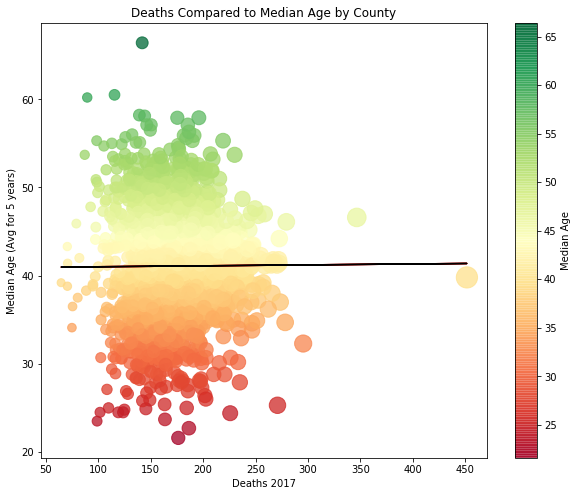

In [29]:
# Compare Deaths to age
x_axis = summary_df.loc[:,"AGE_ADJUSTED_RATE"]
y_axis = summary_df.loc[:,'median age']
s = deathrates_census.loc[:,'AGE_ADJUSTED_RATE']

# Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_axis, y_axis)

# Get regression values
regress_values = x_axis * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)

# Print Pearson's correlation coefficient (rvalue)
print(rvalue)

# Create Plot for Deaths to unemployement
plt.figure(figsize=(10,8))
plt.scatter(x_axis, y_axis, c=y_axis, 
            cmap = 'RdYlGn', s=s, alpha=0.75)
plt.plot(x_axis,regress_values,"r-")

plt.title('Deaths Compared to Median Age by County')
plt.xlabel('Deaths 2017')
plt.ylabel('Median Age (Avg for 5 years)')
plt.plot(x_axis,regress_values,"k-")
cbar = plt.colorbar()
cbar.set_label('Median Age')
plt.show()

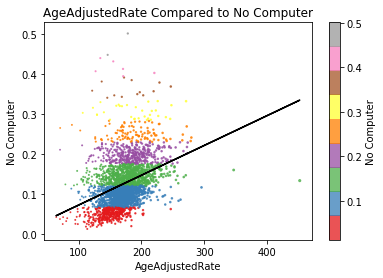

The correlation between rate and No Computer is 0.36


In [14]:
# Compare Deaths to no computure
x_axis = summary_df.loc[:,"AGE_ADJUSTED_RATE"]
y_axis = summary_df.loc[:,'No Computer']

# Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_axis, y_axis)

# Get regression values
regress_values = x_axis * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
# print(line_eq)

# Print Pearson's correlation coefficient (rvalue)
# print(rvalue)

s = summary_df.loc[:,'Ratings']
plt.scatter(x_axis, y_axis, c=y_axis, 
            cmap = 'Set1', s=s, alpha=0.75)
plt.title('AgeAdjustedRate Compared to No Computer')
plt.xlabel('AgeAdjustedRate')
plt.ylabel('No Computer')
plt.plot(x_axis,regress_values,"k-")
cbar = plt.colorbar()
cbar.set_label('No Computer')
plt.show()

rate = summary_df.iloc[:,2]
factor = summary_df.iloc[:,11]
correlation = sts.pearsonr(rate,factor)
print(f"The correlation between rate and No Computer is {round(rvalue,2)}")

y = 0.0x +0.01
0.4031878482268183


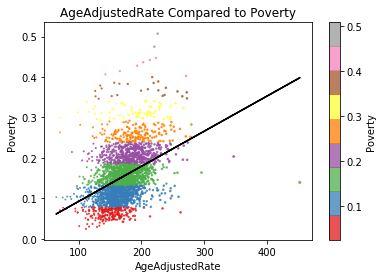

In [15]:
# Compare Deaths to median household income
x_axis = summary_df.loc[:,"AGE_ADJUSTED_RATE"]
y_axis = summary_df.loc[:,'Poverty']

# Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_axis, y_axis)

# Get regression values
regress_values = x_axis * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)

# Print Pearson's correlation coefficient (rvalue)
print(rvalue)

s = summary_df.loc[:,'Ratings']
plt.scatter(x_axis, y_axis, c=y_axis, 
            cmap = 'Set1', s=s, alpha=0.75)
plt.title('AgeAdjustedRate Compared to Poverty')
plt.xlabel('AgeAdjustedRate')
plt.ylabel('Poverty')
plt.plot(x_axis,regress_values,"k-")
cbar = plt.colorbar()
cbar.set_label('Poverty')
plt.show()

y = 0.0x +0.1
0.06849552123917456


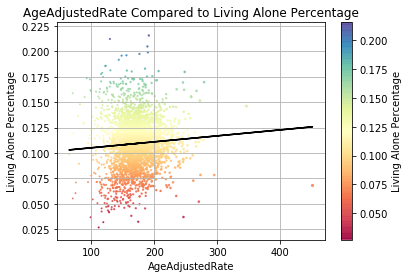

The correlation between rate and Living Alone is 0.07


In [16]:
# Compare Deaths to Living Alone Percentage
x_axis = summary_df.loc[:,"AGE_ADJUSTED_RATE"]
y_axis = summary_df.loc[:,'Living Alone Percentage']

# Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_axis, y_axis)

# Get regression values
regress_values = x_axis * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)

# Print Pearson's correlation coefficient (rvalue)
print(rvalue)

s = deathrates_census.loc[:,'Ratings']
plt.scatter(x_axis, y_axis, c=y_axis, 
            cmap = 'Spectral', s=s, alpha=0.75)
plt.title('AgeAdjustedRate Compared to Living Alone Percentage')
plt.xlabel('AgeAdjustedRate')
plt.ylabel('Living Alone Percentage')
plt.grid(True)
plt.plot(x_axis,regress_values,"k-")
cbar = plt.colorbar()
cbar.set_label('Living Alone Percentage')
plt.show()

rate = summary_df.iloc[:,2]
factor = summary_df.iloc[:,7]
correlation = sts.pearsonr(rate,factor)
print(f"The correlation between rate and Living Alone is {round(correlation[0],2)}")

y = 0.0x +-0.0
0.3390666510892387


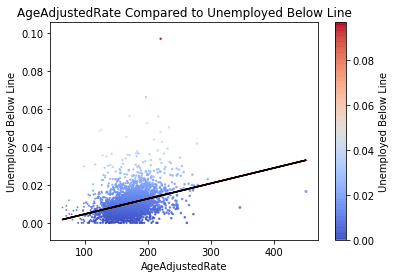

In [17]:
# Compare Deaths to unemployement
x_axis = summary_df.loc[:,"AGE_ADJUSTED_RATE"]
y_axis = summary_df.loc[:,'Unemployed Below Line']
s = deathrates_census.loc[:,'Ratings']

# Perform a linear regression on temperature vs. latitude
(slope, intercept, rvalue, pvalue, stderr) = stats.linregress(x_axis, y_axis)

# Get regression values
regress_values = x_axis * slope + intercept

# Create line equation string
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))
print(line_eq)

# Print Pearson's correlation coefficient (rvalue)
print(rvalue)

# Create Plot for Deaths to unemployement
plt.scatter(x_axis, y_axis, c=y_axis, 
            cmap = 'coolwarm', s=s, alpha=0.75)
plt.plot(x_axis,regress_values,"r-")

plt.title('AgeAdjustedRate Compared to Unemployed Below Line')
plt.xlabel('AgeAdjustedRate')
plt.ylabel('Unemployed Below Line')
plt.plot(x_axis,regress_values,"k-")
cbar = plt.colorbar()
cbar.set_label('Unemployed Below Line')
plt.show()

In [19]:
# Plot map for cancer deaths per population
locations = summary_df[["lat", "lng"]]

# Fill NaN values and convert to float
rating = summary_df["Ratings"].astype(float)

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=rating, 
                                 dissipating=False, max_intensity=20,
                                 point_radius=1)

# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [20]:
# Plot map for living alone per population
locations = summary_df[["lat", "lng"]]

# Fill NaN values and convert to float
rating = summary_df["Living Alone Percentage"].astype(float)

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=rating, 
                                 dissipating=False, max_intensity=0,
                                 point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [21]:
# Plot map for poverty per population
locations = summary_df[["lat", "lng"]]

# Fill NaN values and convert to float
rating = summary_df["Poverty"].astype(float)

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=rating, 
                                 dissipating=False, max_intensity=0,
                                 point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [22]:
# Plot map for population size per population
locations = summary_df[["lat", "lng"]]

# Fill NaN values and convert to float
rating = summary_df["population size"].astype(float)

# Plot Heatmap
fig = gmaps.figure()

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations, weights=rating, 
                                 dissipating=False, max_intensity=0,
                                 point_radius=1)


# Add layer
fig.add_layer(heat_layer)

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

In [23]:
# Plot out all corrilations
corr=summary_df.corr()
corr.style.background_gradient(cmap='coolwarm', axis=0)

,AGE_ADJUSTED_RATE,Ratings,Never Married Percentage,Unemployed Below Line,No Insurance,Living Alone Percentage,median age,median household income,Poverty,No Computer,lat,lng,population size
AGE_ADJUSTED_RATE,1.000000,1.000000,0.201565,0.339067,-0.054859,0.068496,0.005677,-0.447135,0.403188,0.360322,-0.164409,0.248803,-0.145499
Ratings,1.000000,1.000000,0.201565,0.339067,-0.054859,0.068496,0.005677,-0.447135,0.403188,0.360322,-0.164409,0.248803,-0.145499
Never Married Percentage,0.201565,0.201565,1.000000,0.781524,0.049068,-0.075851,-0.288331,-0.249101,0.525378,0.216465,-0.167905,0.098870,0.113982
Unemployed Below Line,0.339067,0.339067,0.781524,1.000000,0.016869,0.001508,-0.169771,-0.472249,0.705246,0.393381,-0.224219,0.090296,0.010398
No Insurance,-0.054859,-0.054859,0.049068,0.016869,1.000000,-0.005885,-0.068559,0.081028,0.072674,0.028032,0.115155,-0.099298,0.027275
Living Alone Percentage,0.068496,0.068496,-0.075851,0.001508,-0.005885,1.000000,0.509363,-0.319346,0.055752,0.171680,0.217196,0.045618,-0.089975
median age,0.005677,0.005677,-0.288331,-0.169771,-0.068559,0.509363,1.000000,-0.121358,-0.201766,0.156865,0.145047,0.094214,-0.176935
median household income,-0.447135,-0.447135,-0.249101,-0.472249,0.081028,-0.319346,-0.121358,1.000000,-0.749535,-0.701351,0.289084,-0.068860,0.254462
Poverty,0.403188,0.403188,0.525378,0.705246,0.072674,0.055752,-0.201766,-0.749535,1.000000,0.665142,-0.363620,0.067420,-0.060892
No Computer,0.360322,0.360322,0.216465,0.393381,0.028032,0.171680,0.156865,-0.701351,0.665142,1.000000,-0.289066,0.132413,-0.211359


In [24]:
# create dataset for only those used in presentation
deathrates_census_summary = summary_df[['AGE_ADJUSTED_RATE',"median age","median household income","Unemployed Below Line","No Insurance","Living Alone Percentage","Never Married Percentage","Poverty"]]

In [25]:
# Plot correlations for only those used in presentation
corr=deathrates_census_summary.corr()
corr.style.background_gradient(cmap='coolwarm', axis=0)

,AGE_ADJUSTED_RATE,median age,median household income,Unemployed Below Line,No Insurance,Living Alone Percentage,Never Married Percentage,Poverty
AGE_ADJUSTED_RATE,1.000000,0.005677,-0.447135,0.339067,-0.054859,0.068496,0.201565,0.403188
median age,0.005677,1.000000,-0.121358,-0.169771,-0.068559,0.509363,-0.288331,-0.201766
median household income,-0.447135,-0.121358,1.000000,-0.472249,0.081028,-0.319346,-0.249101,-0.749535
Unemployed Below Line,0.339067,-0.169771,-0.472249,1.000000,0.016869,0.001508,0.781524,0.705246
No Insurance,-0.054859,-0.068559,0.081028,0.016869,1.000000,-0.005885,0.049068,0.072674
Living Alone Percentage,0.068496,0.509363,-0.319346,0.001508,-0.005885,1.000000,-0.075851,0.055752
Never Married Percentage,0.201565,-0.288331,-0.249101,0.781524,0.049068,-0.075851,1.000000,0.525378
Poverty,0.403188,-0.201766,-0.749535,0.705246,0.072674,0.055752,0.525378,1.000000
